<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# To get summaries of the models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Code Challenge: Width of FC Layer

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Create the Gaussian Data Set

In [13]:
# Number of images and image size
nPerClass = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# The two widths of the Gaussian: class1 and class2 in arbitrary units
# Width represents the variance in the equation
widths = [1.8, 2.4]

# Initialize tensots containing images and labels
images = torch.zeros(2*nPerClass ,1 ,imgsize, imgsize)
labels = torch.zeros(2*nPerClass)

# Create the images
for i in range(2*nPerClass):

    # Create Gaussians with random centers
    ro = 2*np.random.randn(2) # ro: random offset
    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/5

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)
    labels[i] = i%2

# Make labels as 1d matrix
labels = labels[:,None]

print(images.shape)

torch.Size([2000, 1, 91, 91])


In [14]:
# Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the Class

In [15]:
def makeTheNet(fcUnits):

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Create all layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Flatten(),
                nn.Linear(22*22*4,2*fcUnits),
                nn.ReLU(),
                nn.Linear(2*fcUnits,fcUnits), # Added the second FC Layer
                nn.Linear(fcUnits,1),
                )
            
        def forward(self,x):
            return self.enc(x)

    # Create the model instance
    net = GaussNet()

    # Loss Function
    lossfun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [18]:
def function2trainThemodel(fcUnits):

    # Define the number of epochs
    numepochs = 10

    # Create a new model instance
    net, lossfun, optimizer = makeTheNet(fcUnits)

    # Send the model to the GPU
    net.to(device)

    # initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # Data to the GPU
            X = X.to(device)
            y = y.to(device)

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())

            # Compute the accuracy of the batch
            batchAcc.append(100*torch.mean(((yHat>0) ==y).float()).item())
        # End of he batch loop

        # Get the values for training accuracy of a single epoch
        trainAcc.append(np.mean(batchAcc))

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))

        # Push data to the GPU
        X = X.to(device)
        y = y.to(device)

        # Deactivate the autograd
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean(((yHat>0) ==y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    # End the Epochs
    return trainAcc, testAcc, losses, net

## Run the Model

In [19]:
# Specify the number of hidden units
linearUnits = np.round(np.linspace(5,500,20))

# Initialize the result matrix
results = np.zeros((len(linearUnits),4))

# Run the stuff
for i, nunits in enumerate(linearUnits):
    trainAcc, testAcc, losses, net = function2trainThemodel(int(nunits))
    results[i,:] = [trainAcc[-1], testAcc[-1], losses[0][-1], losses[1][-1]]

# Note: 42 seconds in GPU

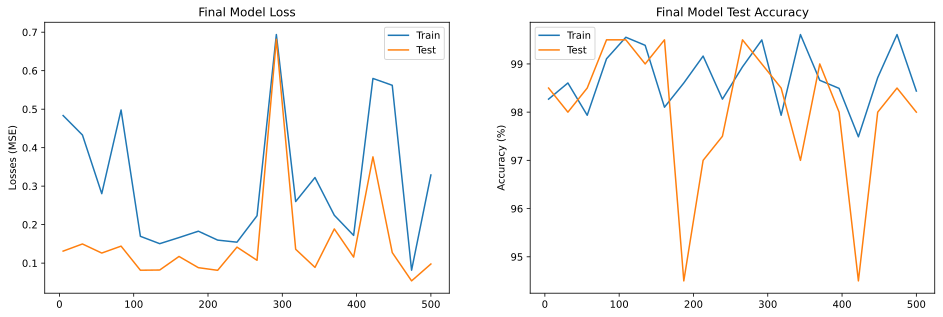

In [21]:
# Visualoze it
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(linearUnits, results[:,2:])
ax[0].set_ylabel("Units in the FC layer")
ax[0].set_ylabel("Losses (MSE)")
ax[0].set_title("Final Model Loss")
ax[0].legend(["Train", "Test"])

ax[1].plot(linearUnits, results[:,:2])
ax[1].set_ylabel("Units in the FC layer")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy")
ax[1].legend(["Train", "Test"])

plt.show()

In [22]:
linearUnits

array([  5.,  31.,  57.,  83., 109., 135., 161., 187., 213., 239., 266.,
       292., 318., 344., 370., 396., 422., 448., 474., 500.])

In [24]:
# The maximum test Accuracy
np.amax(results[:,1])

99.50000047683716

In [26]:
# Index of maximum test accuracy
np.where(results == np.amax(results[:,1]))

(array([ 3,  4,  6, 10]), array([1, 1, 1, 1]))

# CNN Autoencoders

In [9]:
# Create the Gaussian Blurs

# Number of images and image size
nGauss = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# Vary the weights smoothly: Every Gaussian has its own unique parameter
widths = np.linspace(2,20,nGauss)

# Initialize tensots containing images and labels
images = torch.zeros(nGauss,1 ,imgsize, imgsize)

# Create the images
for i in range(nGauss):

    # Create Gaussians with random centers
    ro = 1.5*np.random.randn(2) # ro: random offset
    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i])

    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/5

    # Add Occlusion randomly
    # Any pixel between 2 and 28
    i1 = np.random.choice(np.arange(2,28))
    # Any pixel between 2 and 6
    i2 = np.random.choice(np.arange(2,6))

    # Add the occlusion bar
    if np.random.randn() > 0:
        G[i1:i1+i2,:] = 1
    else:
        G[:,i1:i1+i2] = 1

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)

print(images.shape)

torch.Size([1000, 1, 91, 91])


In [10]:
G.shape

(91, 91)

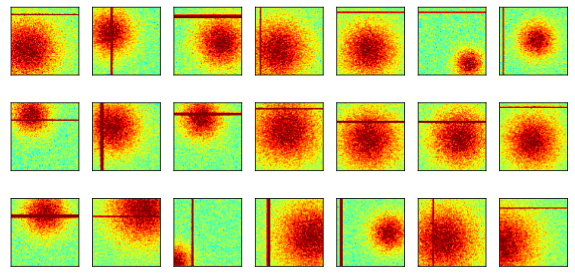

In [14]:
# Show some random images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1,vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create the DL Model

In [15]:
# Create a class for the model
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    lossfun = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [16]:
# Test the model with a batch of 10 images to make sure it works
net, lossfun, optimizer = makeTheNet()

yHat = net(images[:10,:,:,:])
print(yHat.shape)

torch.Size([10, 1, 91, 91])


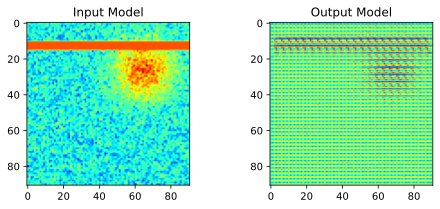

In [18]:
# Visualize jus tto make sure it works: Model is Untrained
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(),cmap="jet")
ax[0].set_title("Input Model")
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap="jet")
ax[1].set_title("Output Model")
plt.show()

In [19]:
# Print a summary of the model
summary(net,(1,imgsize,imgsize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

In [20]:
# Create a function to train the model
def function2trainTheModel():

    # Number of epochs: experimental time
    numepochs = 500

    # create new model instance
    net, lossfun, optimizer = makeTheNet()

    losses = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Pick a set of images at random
        pics2use = np.random.choice(nGauss,size=32,replace=False)
        X = images[pics2use,:,:,:]


        # Forward Pass and Loss
        yHat = net(X)
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)
        losses.append(loss.item())

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # End of epochs loop

    # The final output
    return losses, net

In [21]:
losses, net = function2trainTheModel()

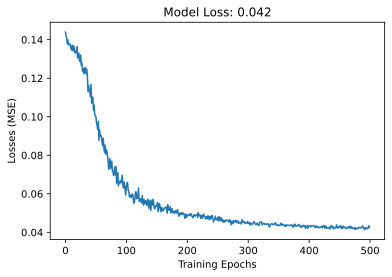

In [24]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

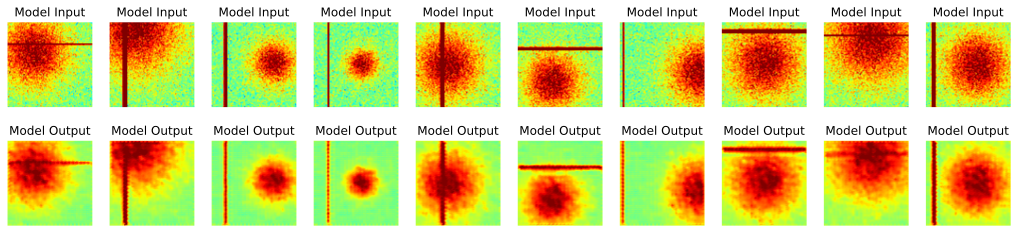

In [25]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Model Input")

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Model Output")

plt.show()
# Autoencoder cleaned some of the noise, but did not rmeove the bars